In [42]:
# BM 336546 - HW2
# Part I: Data Exploration


In [101]:
# Loading Data

import pandas as pd 
import numpy as np
import numpy.replace as rep
from pathlib import Path
import random
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import hinge_loss
%load_ext autoreload


T1D_dataset = pd.read_csv("HW2_data.csv") 
T1D = T1D_dataset[['Age','Gender','Increased Urination','Increased Thirst','Sudden Weight Loss','Weakness','Increased Hunger',
                            'Genital Thrush','Visual Blurring','Itching','Irritability','Delayed Healing','Partial Paresis',
                            'Muscle Stiffness','Hair Loss','Obesity','Family History']]
Diagnosis = T1D_dataset[['Diagnosis']]

random.seed(10)  # fill your seed number here
T1D.sample(n=5, random_state=5)

T1D_features=T1D.copy()


ModuleNotFoundError: No module named 'numpy.replace'

In [44]:
# replacing nans with samples

i=T1D_features.columns.values

T1Dc_features={}    
for x in i:
    Q = T1D_features[x]
    null_ind=np.where(Q.isnull())[0]
   
    for ii in null_ind:
        Q.iloc[ii] = Q[np.random.choice(np.where(Q.notnull())[0])]
    T1Dc_features[x] = Q
    

T1Dc_features=pd.DataFrame(T1Dc_features)
T1Dc_features.sample(n=5, random_state=5)


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Family History
197,62,Male,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,0
330,40,Male,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,1
261,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
336,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1
539,67,Male,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,0


In [45]:
T1Dc_features = pd.get_dummies(data=T1Dc_features, drop_first=True)
T1Dc_features.sample(n=5, random_state=5)


,Age,Family History,Gender_Male,Increased Urination_Yes,Increased Thirst_Yes,Sudden Weight Loss_Yes,Weakness_Yes,Increased Hunger_Yes,Genital Thrush_Yes,Visual Blurring_Yes,Itching_Yes,Irritability_Yes,Delayed Healing_Yes,Partial Paresis_Yes,Muscle Stiffness_Yes,Hair Loss_Yes,Obesity_Yes
197,62,0,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0
330,40,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
261,30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
336,30,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
539,67,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0


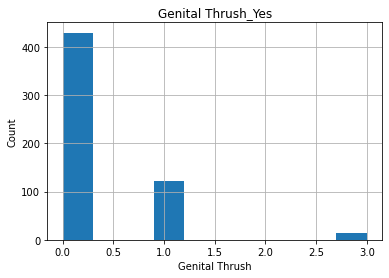

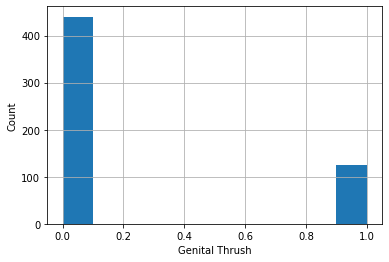

In [46]:
import matplotlib.pyplot as plt


feat = 'Genital Thrush'
Q = pd.DataFrame(T1D[feat])

idx_na = Q.index[Q[feat].isnull()].tolist()
Q = pd.get_dummies(data=Q, drop_first=True)


for i in idx_na:
    Q.loc[i] = 3



Q.hist(bins = 10)

plt.xlabel('Genital Thrush')
plt.ylabel('Count')
plt.show()

T1Dc_features['Genital Thrush_Yes'].hist(bins = 10)
plt.xlabel('Genital Thrush')
plt.ylabel('Count')
plt.show()

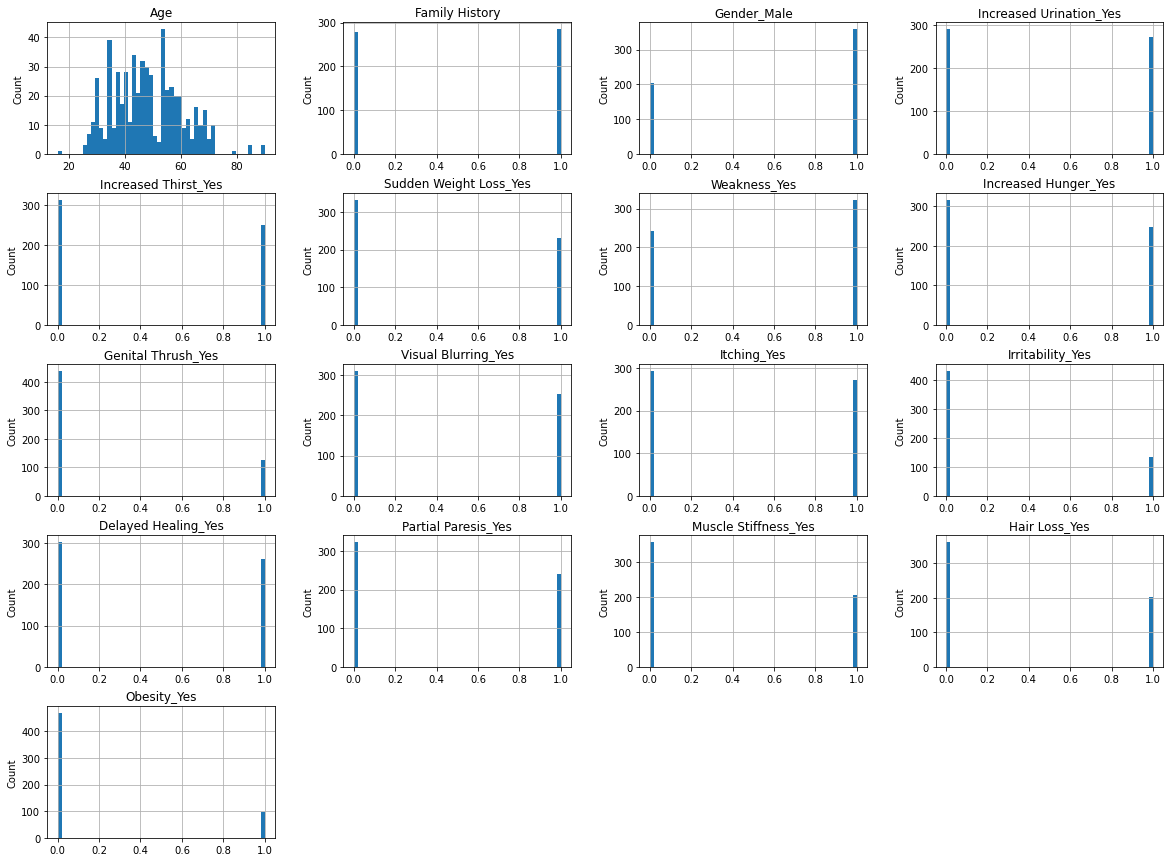

In [47]:
axarr = T1Dc_features.hist(bins=50, figsize=(20, 15)) # histograms of dataframe variables
for idx, ax in enumerate(axarr.flatten()):
#     ax.set_xlabel(i[idx])
    ax.set_ylabel("Count")
plt.show()

In [48]:
from sklearn import metrics
from sklearn.model_selection import train_test_split


orig_feat = T1Dc_features.columns.values
X_train, X_test, y_train, y_test = train_test_split(T1Dc_features, np.ravel(Diagnosis), test_size=0.2, random_state=0, stratify=np.ravel(Diagnosis))

# print(len(X_train))
# print(len(X_test))
# print(len(y_train))
# print(len(y_test))

In [49]:
tbl1=[]

tbl1={'Train %':X_train.iloc[:,1:].sum()*100/len(X_train)}
tbl1['Test %']=X_test.iloc[:,1:].sum()*100/len(X_test)
tbl1['Delta %']=tbl1['Train %']-tbl1['Test %']
print(pd.DataFrame(tbl1))

                           Train %     Test %   Delta %
Family History           50.221239  52.212389 -1.991150
Gender_Male              63.938053  62.831858  1.106195
Increased Urination_Yes  48.230088  48.672566 -0.442478
Increased Thirst_Yes     45.575221  39.823009  5.752212
Sudden Weight Loss_Yes   39.823009  46.017699 -6.194690
Weakness_Yes             56.415929  60.176991 -3.761062
Increased Hunger_Yes     44.247788  42.477876  1.769912
Genital Thrush_Yes       20.796460  27.433628 -6.637168
Visual Blurring_Yes      45.796460  41.592920  4.203540
Itching_Yes              48.672566  45.132743  3.539823
Irritability_Yes         23.008850  25.663717 -2.654867
Delayed Healing_Yes      46.902655  43.362832  3.539823
Partial Paresis_Yes      42.699115  42.477876  0.221239
Muscle Stiffness_Yes     36.504425  36.283186  0.221239
Hair Loss_Yes            34.292035  41.592920 -7.300885
Obesity_Yes              17.477876  14.159292  3.318584


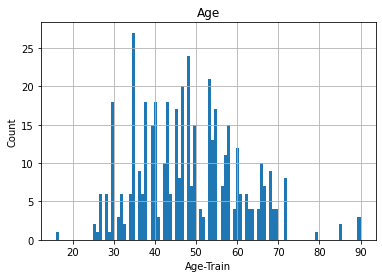

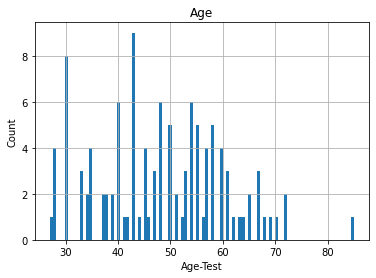

In [50]:
import matplotlib.pyplot as plt


feat = 'Age'
Q=X_train[[feat]]
Q.hist(bins = 100)

plt.xlabel('Age-Train')
plt.ylabel('Count')
plt.show()

q=X_test[['Age']]
q.hist(bins = 100)

plt.xlabel('Age-Test')
plt.ylabel('Count')
plt.show()



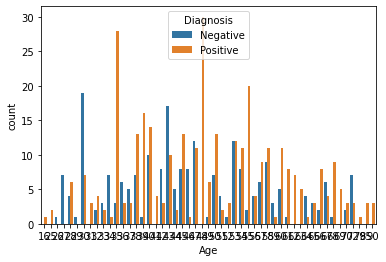

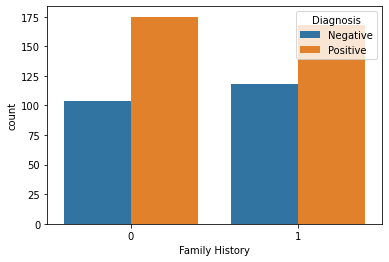

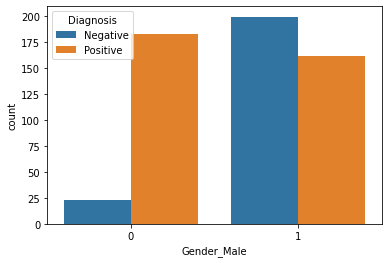

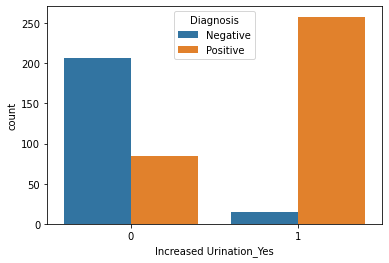

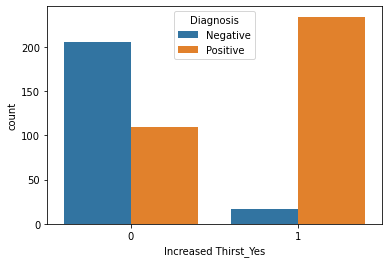

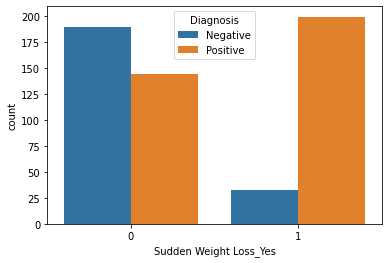

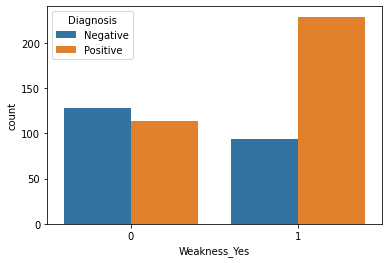

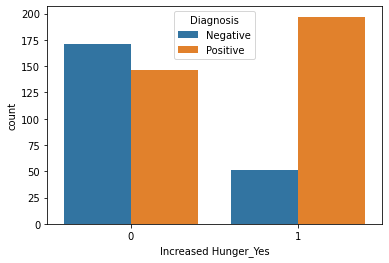

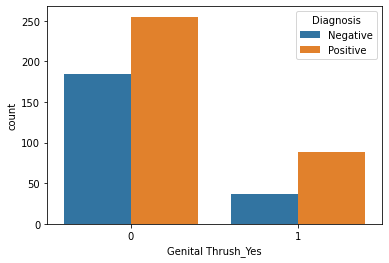

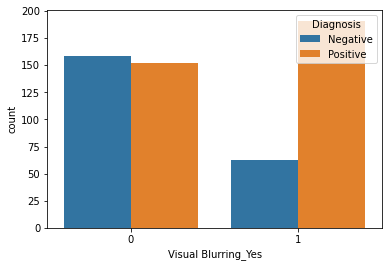

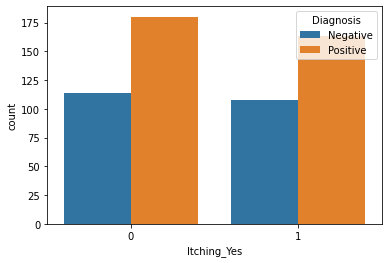

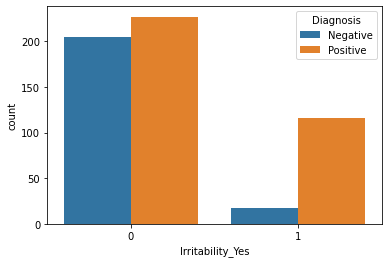

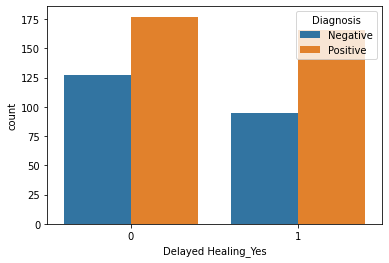

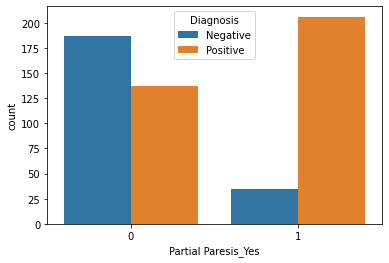

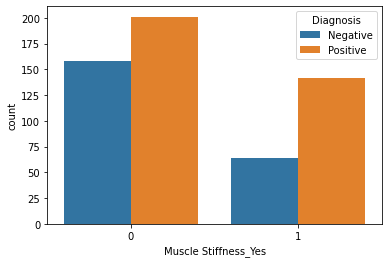

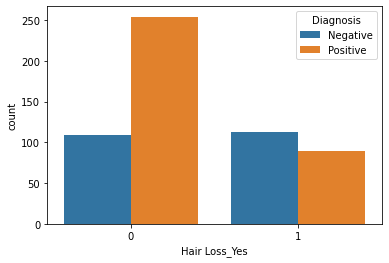

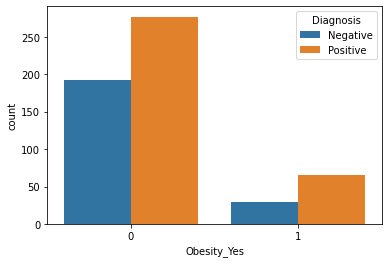

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

data_plotting=T1Dc_features.copy()
data_plotting['Diagnosis']=Diagnosis
features = T1Dc_features.columns.values
for feat in features:
    ax = sns.countplot(x=feat, hue="Diagnosis", data=data_plotting) 
   
    plt.show()
    

<AxesSubplot:>

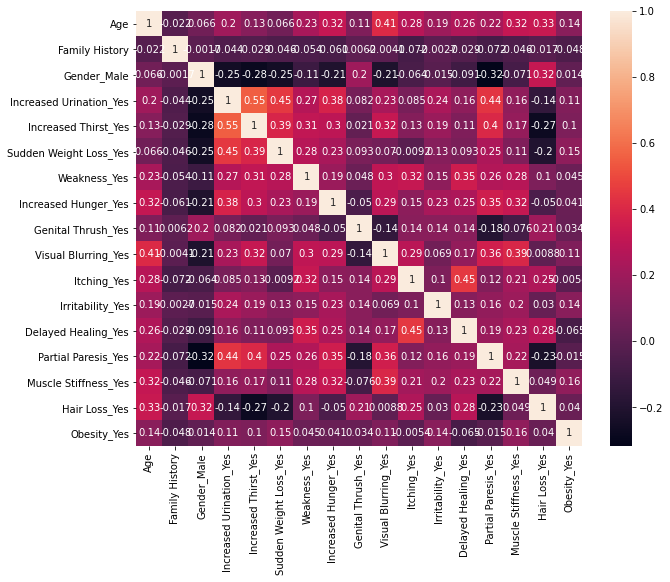

In [52]:
plt.figure(figsize = (10,8))
sns.heatmap(T1Dc_features.corr(), annot = True)

In [53]:
hot_vector=data_plotting.copy()
hot_vector['Diagnosis']=pd.get_dummies(data=hot_vector['Diagnosis'],drop_first=True)
del hot_vector['Age']
print(hot_vector)

     Family History  Gender_Male  Increased Urination_Yes  \
0                 0            1                        0   
1                 0            1                        0   
2                 0            1                        1   
3                 1            0                        0   
4                 0            0                        1   
..              ...          ...                      ...   
560               0            1                        1   
561               0            1                        0   
562               1            0                        1   
563               0            1                        0   
564               0            1                        0   

     Increased Thirst_Yes  Sudden Weight Loss_Yes  Weakness_Yes  \
0                       0                       0             1   
1                       0                       0             0   
2                       1                       0             1   

In [54]:
def plot_radar(clf, clf_type):
    labels=np.array(['Accuracy', 'F1', 'PPV', 'Sensitivity', 'AUROC']) 
    score_mat_train = np.stack((clf.cv_results_['mean_train_accuracy'], clf.cv_results_['mean_train_f1'],
                               clf.cv_results_['mean_train_precision'], clf.cv_results_['mean_train_recall'],
                               clf.cv_results_['mean_train_roc_auc']), axis=0)
    score_mat_val = np.stack((clf.cv_results_['mean_test_accuracy'], clf.cv_results_['mean_test_f1'],
                               clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall'],
                               clf.cv_results_['mean_test_roc_auc']), axis=0)


    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    angles=np.concatenate((angles,[angles[0]]))
    cv_dict = clf.cv_results_['params']
    fig=plt.figure(figsize=(18,14))
    if 'svm__gamma' in cv_dict[0]:
        new_list = [(i, item) for i, item in enumerate(cv_dict) if
                    item["svm__kernel"] == clf_type[0] and item["svm__gamma"] == clf_type[1]]
    else:
        new_list = [(i, item) for i, item in enumerate(cv_dict) if
                    item["svm__kernel"] == clf_type[0]]
    for idx, val in enumerate(new_list):
        ax = fig.add_subplot(1, len(new_list), 1+idx, polar=True)
        rel_idx, rel_dict = val
        stats_train = score_mat_train[:, rel_idx]
        stats_train=np.concatenate((stats_train,[stats_train[0]]))
        ax.plot(angles, stats_train, 'o-', linewidth=2)
        ax.fill(angles, stats_train, alpha=0.25)
        stats_val = score_mat_val[:, rel_idx]
        stats_val=np.concatenate((stats_val,[stats_val[0]]))
        ax.plot(angles, stats_val, 'o-', linewidth=2)
        ax.fill(angles, stats_val, alpha=0.25)
        ax.set_thetagrids(angles[0:-1] * 180/np.pi, labels)
        if idx == 0:
            ax.set_ylabel(clf_type[0], fontsize=18)
        ax.set_title('C = %.3f' % (rel_dict['svm__C']))
        if 'svm__gamma' in cv_dict[0]:
            ax.set_xlabel('$\gamma = %s $' % (rel_dict['svm__gamma']))
        ax.set_ylim([0,1])
        ax.legend(['Train','Validation'])
        ax.grid(True)
        
    plt.show()

In [55]:
#Linear section 5-1

from sklearn.model_selection import StratifiedKFold
y_train = pd.get_dummies(data=y_train, drop_first=True)
y_test = pd.get_dummies(data=y_test, drop_first=True)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)


svc = SVC(probability=True)
C = np.array([0.001, 0.01, 1, 10, 100, 1000])

pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
svm_lin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['linear']},cv=skf,
                       scoring=['accuracy','f1','precision','recall','roc_auc'], 
                       refit='roc_auc', verbose=3, return_train_score=True)
svm_lin.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.864, test=0.802), f1=(train=0.895, test=0.850), precision=(train=0.843, test=0.785), recall=(train=0.954, test=0.927), roc_auc=(train=0.952, test=0.914), total=   0.1s
[CV] svm__C=0.001, svm__kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.809, test=0.835), f1=(train=0.860, test=0.878), precision=(train=0.774, test=0.794), recall=(train=0.968, test=0.982), roc_auc=(train=0.953, test=0.972), total=   0.1s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.854, test=0.789), f1=(train=0.887, test=0.838), precision=(train=0.833, test=0.778), recall=(train=0.950, test=0.907), roc_auc=(train=0.956, test=0.918), total=   0.1s
[CV] svm__C=0.001, svm__kernel=linear ................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.812, test=0.811), f1=(train=0.863, test=0.862), precision=(train=0.773, test=0.779), recall=(train=0.977, test=0.964), roc_auc=(train=0.952, test=0.961), total=   0.1s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.809, test=0.844), f1=(train=0.861, test=0.883), precision=(train=0.772, test=0.815), recall=(train=0.973, test=0.964), roc_auc=(train=0.951, test=0.951), total=   0.1s
[CV] svm__C=0.01, svm__kernel=linear .................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.900, test=0.879), f1=(train=0.915, test=0.899), precision=(train=0.946, test=0.907), recall=(train=0.886, test=0.891), roc_auc=(train=0.974, test=0.957), total=   0.1s
[CV] svm__C=0.01, svm__kernel=linear .................................
[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.903, test=0.923), f1=(train=0.919, test=0.935), precision=(train=0.934, test=0.962), recall=(train=0.904, test=0.909), roc_auc=(train=0.971, test=0.979), total=   0.1s
[CV] svm__C=0.01, svm__kernel=linear .................................
[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.923, test=0.878), f1=(train=0.935, test=0.893), precision=(train=0.957, test=0.939), recall=(train=0.914, test=0.852), roc_auc=(train=0.975, test=0.944), total=   0.0s
[CV] svm__C=0.01, svm__kernel=linear .................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.898, test=0.900), f1=(train=0.915, test=0.920), precision=(train=0.925, test=0.897), recall=(train=0.904, test=0.945), roc_auc=(train=0.974, test=0.966), total=   0.0s
[CV] svm__C=0.01, svm__kernel=linear .................................
[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.906, test=0.889), f1=(train=0.921, test=0.911), precision=(train=0.943, test=0.895), recall=(train=0.900, test=0.927), roc_auc=(train=0.970, test=0.965), total=   0.1s
[CV] svm__C=1.0, svm__kernel=linear ..................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.942, test=0.868), f1=(train=0.952, test=0.891), precision=(train=0.950, test=0.891), recall=(train=0.954, test=0.891), roc_auc=(train=0.981, test=0.958), total=   0.1s
[CV] svm__C=1.0, svm__kernel=linear ..................................
[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.939, test=0.934), f1=(train=0.950, test=0.944), precision=(train=0.946, test=0.962), recall=(train=0.954, test=0.927), roc_auc=(train=0.979, test=0.969), total=   0.1s
[CV] svm__C=1.0, svm__kernel=linear ..................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.948, test=0.889), f1=(train=0.956, test=0.907), precision=(train=0.967, test=0.907), recall=(train=0.945, test=0.907), roc_auc=(train=0.974, test=0.936), total=   0.1s
[CV] svm__C=1.0, svm__kernel=linear ..................................
[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.925, test=0.900), f1=(train=0.939, test=0.920), precision=(train=0.929, test=0.897), recall=(train=0.950, test=0.945), roc_auc=(train=0.978, test=0.970), total=   0.1s
[CV] svm__C=1.0, svm__kernel=linear ..................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.925, test=0.922), f1=(train=0.938, test=0.938), precision=(train=0.940, test=0.914), recall=(train=0.936, test=0.964), roc_auc=(train=0.976, test=0.971), total=   0.1s
[CV] svm__C=10.0, svm__kernel=linear .................................
[CV]  svm__C=10.0, svm__kernel=linear, accuracy=(train=0.950, test=0.890), f1=(train=0.959, test=0.907), precision=(train=0.967, test=0.925), recall=(train=0.950, test=0.891), roc_auc=(train=0.981, test=0.954), total=   0.2s
[CV] svm__C=10.0, svm__kernel=linear .................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=10.0, svm__kernel=linear, accuracy=(train=0.928, test=0.923), f1=(train=0.940, test=0.935), precision=(train=0.945, test=0.962), recall=(train=0.936, test=0.909), roc_auc=(train=0.979, test=0.972), total=   0.2s
[CV] svm__C=10.0, svm__kernel=linear .................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=10.0, svm__kernel=linear, accuracy=(train=0.948, test=0.878), f1=(train=0.956, test=0.897), precision=(train=0.967, test=0.906), recall=(train=0.945, test=0.889), roc_auc=(train=0.974, test=0.939), total=   0.2s
[CV] svm__C=10.0, svm__kernel=linear .................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=10.0, svm__kernel=linear, accuracy=(train=0.931, test=0.900), f1=(train=0.943, test=0.920), precision=(train=0.937, test=0.897), recall=(train=0.950, test=0.945), roc_auc=(train=0.977, test=0.971), total=   0.2s
[CV] svm__C=10.0, svm__kernel=linear .................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=10.0, svm__kernel=linear, accuracy=(train=0.923, test=0.922), f1=(train=0.936, test=0.938), precision=(train=0.932, test=0.914), recall=(train=0.941, test=0.964), roc_auc=(train=0.975, test=0.965), total=   0.2s
[CV] svm__C=100.0, svm__kernel=linear ................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100.0, svm__kernel=linear, accuracy=(train=0.958, test=0.901), f1=(train=0.966, test=0.916), precision=(train=0.972, test=0.942), recall=(train=0.959, test=0.891), roc_auc=(train=0.980, test=0.948), total=   1.9s
[CV] svm__C=100.0, svm__kernel=linear ................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100.0, svm__kernel=linear, accuracy=(train=0.931, test=0.912), f1=(train=0.943, test=0.925), precision=(train=0.949, test=0.961), recall=(train=0.936, test=0.891), roc_auc=(train=0.978, test=0.971), total=   1.4s
[CV] svm__C=100.0, svm__kernel=linear ................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100.0, svm__kernel=linear, accuracy=(train=0.948, test=0.878), f1=(train=0.956, test=0.897), precision=(train=0.967, test=0.906), recall=(train=0.945, test=0.889), roc_auc=(train=0.974, test=0.939), total=   1.2s
[CV] svm__C=100.0, svm__kernel=linear ................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100.0, svm__kernel=linear, accuracy=(train=0.931, test=0.900), f1=(train=0.943, test=0.920), precision=(train=0.937, test=0.897), recall=(train=0.950, test=0.945), roc_auc=(train=0.977, test=0.971), total=   1.1s
[CV] svm__C=100.0, svm__kernel=linear ................................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100.0, svm__kernel=linear, accuracy=(train=0.931, test=0.922), f1=(train=0.944, test=0.938), precision=(train=0.933, test=0.914), recall=(train=0.954, test=0.964), roc_auc=(train=0.976, test=0.971), total=   0.8s
[CV] svm__C=1000.0, svm__kernel=linear ...............................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000.0, svm__kernel=linear, accuracy=(train=0.958, test=0.890), f1=(train=0.966, test=0.907), precision=(train=0.972, test=0.925), recall=(train=0.959, test=0.891), roc_auc=(train=0.980, test=0.948), total=   8.4s
[CV] svm__C=1000.0, svm__kernel=linear ...............................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000.0, svm__kernel=linear, accuracy=(train=0.931, test=0.912), f1=(train=0.943, test=0.925), precision=(train=0.949, test=0.961), recall=(train=0.936, test=0.891), roc_auc=(train=0.978, test=0.971), total=  13.4s
[CV] svm__C=1000.0, svm__kernel=linear ...............................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000.0, svm__kernel=linear, accuracy=(train=0.948, test=0.878), f1=(train=0.956, test=0.897), precision=(train=0.967, test=0.906), recall=(train=0.945, test=0.889), roc_auc=(train=0.974, test=0.939), total=  28.4s
[CV] svm__C=1000.0, svm__kernel=linear ...............................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000.0, svm__kernel=linear, accuracy=(train=0.931, test=0.900), f1=(train=0.943, test=0.920), precision=(train=0.937, test=0.897), recall=(train=0.950, test=0.945), roc_auc=(train=0.977, test=0.971), total=  14.0s
[CV] svm__C=1000.0, svm__kernel=linear ...............................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000.0, svm__kernel=linear, accuracy=(train=0.928, test=0.933), f1=(train=0.941, test=0.947), precision=(train=0.933, test=0.915), recall=(train=0.950, test=0.982), roc_auc=(train=0.976, test=0.973), total=  12.0s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__kernel': ['linear']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [56]:
best_svm_lin = svm_lin.best_estimator_
print(svm_lin.best_params_)

{'svm__C': 0.01, 'svm__kernel': 'linear'}


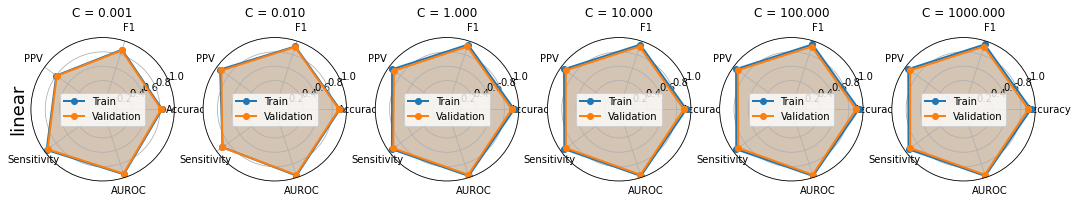

In [57]:
clf_type = ['linear']
plot_radar(svm_lin,clf_type)

In [58]:
from sklearn.metrics import confusion_matrix
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

Sensitivity is 0.91
Specificity is 0.86
PPV is 0.91
NPV is 0.86
Accuracy is 0.89
F1 is 0.91
LOSS is 0.21
AUROC is 0.951


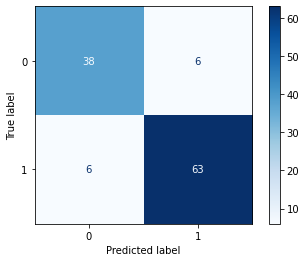

In [107]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score

y_pred_test = best_svm_lin.predict(X_test) #NOTICE NOT TO USE THE STANDARDIZED DATA.
y_pred_proba_test = best_svm_lin.predict_proba(X_test)
#--------------------------Impelment your code here:-------------------------------------
y_pred_test_sc=np.where(y_pred_test==0, -1, y_pred_test)
y_test_sc=np.where(y_test==0, -1, y_test)

TN = calc_TN(y_test, y_pred_test)
TP = calc_TP(y_test, y_pred_test)
FN = calc_FN(y_test, y_pred_test)
FP = calc_FP(y_test, y_pred_test)
Se = TP/(TP+FN)
Sp = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
Acc = (TP+TN)/(TP+TN+FP+FN)
F1 = (2*PPV*Se)/(PPV+Se)
LOSS=hinge_loss(y_test_sc,y_pred_test_sc)
print(f'Sensitivity is {Se:.2f}')
print(f'Specificity is {Sp:.2f}')
print(f'PPV is {PPV:.2f}')
print(f'NPV is {NPV:.2f}')
print(f'Accuracy is {Acc:.2f}')
print(f'F1 is {F1:.2f}')
print(f'LOSS is {LOSS:.2f}')
plot_confusion_matrix(svm_lin, X_test, y_test, cmap=plt.cm.Blues)
plt.grid(False)
#------------------------------------------------------------------------------------------
print('AUROC is {:.3f}'.format(roc_auc_score(y_test, y_pred_proba_test[:,1])))

In [81]:
#logistic
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg=LogisticRegression(random_state=10)
log_reg.fit(X_train_scaled, np.ravel(y_train))

LogisticRegression(random_state=10)

In [71]:
from sklearn.metrics import confusion_matrix
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

Sensitivity is 0.93
Specificity is 0.84
PPV is 0.90
NPV is 0.88
Accuracy is 0.89
F1 is 0.91
LOSS is 3.67
AUROC is 0.959


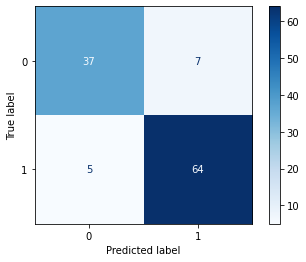

In [82]:
y_pred_test = log_reg.predict(X_test_scaled) #NOTICE NOT TO USE THE STANDARDIZED DATA.
y_pred_proba_test = log_reg.predict_proba(X_test_scaled)
#--------------------------Impelment your code here:-------------------------------------
TN = calc_TN(y_test, y_pred_test)
TP = calc_TP(y_test, y_pred_test)
FN = calc_FN(y_test, y_pred_test)
FP = calc_FP(y_test, y_pred_test)
Se = TP/(TP+FN)
Sp = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
Acc = (TP+TN)/(TP+TN+FP+FN)
F1 = (2*PPV*Se)/(PPV+Se)
LOSS=log_loss(y_test,y_pred_test)
print(f'Sensitivity is {Se:.2f}')
print(f'Specificity is {Sp:.2f}')
print(f'PPV is {PPV:.2f}')
print(f'NPV is {NPV:.2f}')
print(f'Accuracy is {Acc:.2f}')
print(f'F1 is {F1:.2f}')
print(f'LOSS is {LOSS:.2f}')
plot_confusion_matrix(log_reg, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.grid(False)
#------------------------------------------------------------------------------------------
print('AUROC is {:.3f}'.format(roc_auc_score(y_test, y_pred_proba_test[:,1])))

In [61]:
C = np.array([1, 100, 1000])#, 10, 100, 1000])
pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
svm_nonlin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly'],
                                                      'svm__gamma': ['auto', 'scale']},
                       scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                       refit='roc_auc', verbose=3, return_train_score=True)
svm_nonlin.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.986, test=0.967), f1=(train=0.989, test=0.972), precision=(train=0.986, test=0.981), recall=(train=0.991, test=0.964), roc_auc=(train=0.999, test=0.993), total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.986, test=0.945), f1=(train=0.989, test=0.954), precision=(train=0.991, test=0.963), recall=(train=0.986, test=0.945), roc_auc=(train=0.999, test=0.995), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.986, test=0.922), f1=(train=0.989, test=0.933), precision=(train=0.986, test=0.961), recall=(train=0.991, test=0.907), roc_auc=(train=0.999, test=0.990), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.983, test=0.978), f1=(train=0.986, test=0.982), precision=(train=0.982, test=0.982), recall=(train=0.991, test=0.982), roc_auc=(train=0.999, test=0.996), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.986, test=0.978), f1=(train=0.989, test=0.982), precision=(train=0.991, test=0.982), recall=(train=0.986, test=0.982), roc_auc=(train=1.000, test=0.998), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=poly .....................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.989, test=0.956), f1=(train=0.991, test=0.964), precision=(train=0.991, test=0.964), recall=(train=0.991, test=0.964), roc_auc=(train=1.000, test=0.993), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=poly .....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.986, test=0.956), f1=(train=0.989, test=0.964), precision=(train=0.991, test=0.964), recall=(train=0.986, test=0.964), roc_auc=(train=1.000, test=0.994), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=poly .....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.986, test=0.922), f1=(train=0.989, test=0.936), precision=(train=0.986, test=0.927), recall=(train=0.991, test=0.944), roc_auc=(train=1.000, test=0.985), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=poly .....................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.989, test=0.956), f1=(train=0.991, test=0.964), precision=(train=0.986, test=0.964), recall=(train=0.995, test=0.964), roc_auc=(train=1.000, test=0.995), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=poly .....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.986, test=0.956), f1=(train=0.988, test=0.964), precision=(train=1.000, test=0.964), recall=(train=0.977, test=0.964), roc_auc=(train=1.000, test=0.997), total=   0.1s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=rbf .....................
[CV]  svm__C=1, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.986, test=0.967), f1=(train=0.989, test=0.972), precision=(train=0.986, test=0.981), recall=(train=0.991, test=0.964), roc_auc=(train=0.999, test=0.993), total=   0.1s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=rbf .....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.986, test=0.945), f1=(train=0.989, test=0.954), precision=(train=0.991, test=0.963), recall=(train=0.986, test=0.945), roc_auc=(train=0.999, test=0.995), total=   0.1s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=rbf .....................
[CV]  svm__C=1, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.986, test=0.922), f1=(train=0.989, test=0.933), precision=(train=0.986, test=0.961), recall=(train=0.991, test=0.907), roc_auc=(train=0.999, test=0.990), total=   0.1s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=rbf .....................
[CV]  svm__C=1, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.983, test=0.978), f1=(train=0.986, test=0.982), precision=(train=0.982, test=0.982), recall=(train=0.991, test=0.982), roc_auc=(train=0.999, test=0.996), total=   0.1s

C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



[CV] svm__C=1, svm__gamma=scale, svm__kernel=rbf .....................
[CV]  svm__C=1, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.986, test=0.978), f1=(train=0.989, test=0.982), precision=(train=0.991, test=0.982), recall=(train=0.986, test=0.982), roc_auc=(train=1.000, test=0.998), total=   0.1s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=poly ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.989, test=0.956), f1=(train=0.991, test=0.964), precision=(train=0.991, test=0.964), recall=(train=0.991, test=0.964), roc_auc=(train=1.000, test=0.993), total=   0.1s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=poly ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.986, test=0.956), f1=(train=0.989, test=0.964), precision=(train=0.991, test=0.964), recall=(train=0.986, test=0.964), roc_auc=(train=1.000, test=0.994), total=   0.2s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=poly ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.986, test=0.922), f1=(train=0.989, test=0.936), precision=(train=0.986, test=0.927), recall=(train=0.991, test=0.944), roc_auc=(train=1.000, test=0.985), total=   0.2s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=poly ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.989, test=0.956), f1=(train=0.991, test=0.964), precision=(train=0.986, test=0.964), recall=(train=0.995, test=0.964), roc_auc=(train=1.000, test=0.995), total=   0.2s
[CV] svm__C=1, svm__gamma=scale, svm__kernel=poly ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.986, test=0.956), f1=(train=0.988, test=0.964), precision=(train=1.000, test=0.964), recall=(train=0.977, test=0.964), roc_auc=(train=1.000, test=0.997), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=rbf ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.997, test=0.978), f1=(train=0.998, test=0.982), precision=(train=0.995, test=0.982), recall=(train=1.000, test=0.982), roc_auc=(train=1.000, test=0.992), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=rbf ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.994, test=0.945), f1=(train=0.995, test=0.954), precision=(train=0.991, test=0.963), recall=(train=1.000, test=0.945), roc_auc=(train=1.000, test=0.994), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=rbf ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.997, test=0.944), f1=(train=0.998, test=0.952), precision=(train=0.995, test=0.980), recall=(train=1.000, test=0.926), roc_auc=(train=1.000, test=0.993), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=rbf ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.994, test=0.967), f1=(train=0.995, test=0.972), precision=(train=1.000, test=1.000), recall=(train=0.991, test=0.945), roc_auc=(train=1.000, test=0.999), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=rbf ....................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.994, test=0.967), f1=(train=0.995, test=0.972), precision=(train=1.000, test=0.981), recall=(train=0.991, test=0.964), roc_auc=(train=1.000, test=0.998), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=poly ...................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.997, test=0.956), f1=(train=0.998, test=0.964), precision=(train=0.995, test=0.964), recall=(train=1.000, test=0.964), roc_auc=(train=1.000, test=0.990), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=poly ...................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.994, test=0.956), f1=(train=0.995, test=0.963), precision=(train=1.000, test=0.981), recall=(train=0.991, test=0.945), roc_auc=(train=1.000, test=0.996), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=poly ...................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.997, test=0.933), f1=(train=0.998, test=0.943), precision=(train=0.995, test=0.962), recall=(train=1.000, test=0.926), roc_auc=(train=1.000, test=0.987), total=   0.2s
[CV] svm__C=100, svm__gamma=auto, svm__kernel=poly ...................
[CV]  svm__C=100, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.994, test=0.944), f1=(train=0.995, test=0.953), precision=(train=1.000, test=0.981), recall=(train=0.991, test=0.927), roc_auc=(train=1.000, test=0.990), total=   0.2s

C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



[CV] svm__C=100, svm__gamma=auto, svm__kernel=poly ...................
[CV]  svm__C=100, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.994, test=0.944), f1=(train=0.995, test=0.953), precision=(train=1.000, test=0.981), recall=(train=0.991, test=0.927), roc_auc=(train=1.000, test=0.992), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=rbf ...................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.997, test=0.978), f1=(train=0.998, test=0.982), precision=(train=0.995, test=0.982), recall=(train=1.000, test=0.982), roc_auc=(train=1.000, test=0.992), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=rbf ...................
[CV]  svm__C=100, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.994, test=0.945), f1=(train=0.995, test=0.954), precision=(train=0.991, test=0.963), recall=(train=1.000, test=0.945), roc_auc=(train=1.000, test=0.994), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=rbf ...................
[CV]  svm__C=100, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.997, test=0.944), f1=(train=0.998, test=0.952), precision=(train=0.995, test=0.980), recall=(train=1.000, test=0.926), roc_auc=(train=1.000, test=0.993), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=rbf ...................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.994, test=0.967), f1=(train=0.995, test=0.972), precision=(train=1.000, test=1.000), recall=(train=0.991, test=0.945), roc_auc=(train=1.000, test=0.999), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=rbf ...................
[CV]  svm__C=100, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.994, test=0.967), f1=(train=0.995, test=0.972), precision=(train=1.000, test=0.981), recall=(train=0.991, test=0.964), roc_auc=(train=1.000, test=0.998), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=poly ..................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.997, test=0.956), f1=(train=0.998, test=0.964), precision=(train=0.995, test=0.964), recall=(train=1.000, test=0.964), roc_auc=(train=1.000, test=0.990), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=poly ..................
[CV]  svm__C=100, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.994, test=0.956), f1=(train=0.995, test=0.963), precision=(train=1.000, test=0.981), recall=(train=0.991, test=0.945), roc_auc=(train=1.000, test=0.996), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=poly ..................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=100, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.997, test=0.933), f1=(train=0.998, test=0.943), precision=(train=0.995, test=0.962), recall=(train=1.000, test=0.926), roc_auc=(train=1.000, test=0.987), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=poly ..................
[CV]  svm__C=100, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.994, test=0.944), f1=(train=0.995, test=0.953), precision=(train=1.000, test=0.981), recall=(train=0.991, test=0.927), roc_auc=(train=1.000, test=0.990), total=   0.1s
[CV] svm__C=100, svm__gamma=scale, svm__kernel=poly ..................
[CV]  svm__C=100, svm__gamma=scale, svm__kernel=poly, accuracy=(train=0.994, test=0.944), f1=(train=0.995, test=0.953), precision=(train=1.000, test=0.981), recall=(train=0.991, test=0.927), roc_auc=(train=1.000, test=0.992), total=   0.0s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=rbf ...................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=1.000, test=0.923), f1=(train=1.000, test=0.935), precision=(train=1.000, test=0.962), recall=(train=1.000, test=0.909), roc_auc=(train=1.000, test=0.971), total=   0.1s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=rbf ...................
[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=1.000, test=0.934), f1=(train=1.000, test=0.943), precision=(train=1.000, test=0.980), recall=(train=1.000, test=0.909), roc_auc=(train=1.000, test=0.960), total=   0.1s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=rbf ...................
[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=1.000, test=0.956), f1=(train=1.000, test=0.962), precision=(train=1.000, test=0.981), recall=(train=1.000, test=0.944), roc_auc=(train=1.000, test=0.952), total=   0.0s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=rbf ...................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=1.000, test=0.978), f1=(train=1.000, test=0.981), precision=(train=1.000, test=1.000), recall=(train=1.000, test=0.964), roc_auc=(train=1.000, test=0.990), total=   0.1s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=rbf ...................
[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=1.000, test=0.944), f1=(train=1.000, test=0.954), precision=(train=1.000, test=0.963), recall=(train=1.000, test=0.945), roc_auc=(train=1.000, test=0.982), total=   0.1s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=poly ..................
[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=poly, accuracy=(train=1.000, test=0.912), f1=(train=1.000, test=0.926), precision=(train=1.000, test=0.943), recall=(train=1.000, test=0.909), roc_auc=(train=1.000, test=0.966), total=   0.1s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=poly ..................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=poly, accuracy=(train=1.000, test=0.967), f1=(train=1.000, test=0.972), precision=(train=1.000, test=0.981), recall=(train=1.000, test=0.964), roc_auc=(train=1.000, test=0.988), total=   0.0s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=poly ..................
[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=poly, accuracy=(train=1.000, test=0.900), f1=(train=1.000, test=0.916), precision=(train=1.000, test=0.925), recall=(train=1.000, test=0.907), roc_auc=(train=1.000, test=0.931), total=   0.1s
[CV] svm__C=1000, svm__gamma=auto, svm__kernel=poly ..................
[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=poly, accuracy=(train=1.000, test=0.922), f1=(train=1.000, test=0.936), precision=(train=1.000, test=0.944), recall=(train=1.000, test=0.927), roc_auc=(train=1.000, test=0.961), total=   0.0s

C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



[CV] svm__C=1000, svm__gamma=auto, svm__kernel=poly ..................
[CV]  svm__C=1000, svm__gamma=auto, svm__kernel=poly, accuracy=(train=1.000, test=0.911), f1=(train=1.000, test=0.925), precision=(train=1.000, test=0.961), recall=(train=1.000, test=0.891), roc_auc=(train=1.000, test=0.963), total=   0.1s
[CV] svm__C=1000, svm__gamma=scale, svm__kernel=rbf ..................
[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=1.000, test=0.923), f1=(train=1.000, test=0.935), precision=(train=1.000, test=0.962), recall=(train=1.000, test=0.909), roc_auc=(train=1.000, test=0.971), total=   0.1s

C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



[CV] svm__C=1000, svm__gamma=scale, svm__kernel=rbf ..................
[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=1.000, test=0.934), f1=(train=1.000, test=0.943), precision=(train=1.000, test=0.980), recall=(train=1.000, test=0.909), roc_auc=(train=1.000, test=0.960), total=   0.1s
[CV] svm__C=1000, svm__gamma=scale, svm__kernel=rbf ..................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=1.000, test=0.956), f1=(train=1.000, test=0.962), precision=(train=1.000, test=0.981), recall=(train=1.000, test=0.944), roc_auc=(train=1.000, test=0.952), total=   0.1s
[CV] svm__C=1000, svm__gamma=scale, svm__kernel=rbf ..................
[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=1.000, test=0.978), f1=(train=1.000, test=0.981), precision=(train=1.000, test=1.000), recall=(train=1.000, test=0.964), roc_auc=(train=1.000, test=0.990), total=   0.1s
[CV] svm__C=1000, svm__gamma=scale, svm__kernel=rbf ..................
[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=1.000, test=0.944), f1=(train=1.000, test=0.954), precision=(train=1.000, test=0.963), recall=(train=1.000, test=0.945), roc_auc=(train=1.000, test=0.982), total=   0.1s

C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



[CV] svm__C=1000, svm__gamma=scale, svm__kernel=poly .................
[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=poly, accuracy=(train=1.000, test=0.912), f1=(train=1.000, test=0.926), precision=(train=1.000, test=0.943), recall=(train=1.000, test=0.909), roc_auc=(train=1.000, test=0.966), total=   0.1s
[CV] svm__C=1000, svm__gamma=scale, svm__kernel=poly .................
[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=poly, accuracy=(train=1.000, test=0.967), f1=(train=1.000, test=0.972), precision=(train=1.000, test=0.981), recall=(train=1.000, test=0.964), roc_auc=(train=1.000, test=0.988), total=   0.0s
[CV] svm__C=1000, svm__gamma=scale, svm__kernel=poly .................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=poly, accuracy=(train=1.000, test=0.900), f1=(train=1.000, test=0.916), precision=(train=1.000, test=0.925), recall=(train=1.000, test=0.907), roc_auc=(train=1.000, test=0.931), total=   0.1s
[CV] svm__C=1000, svm__gamma=scale, svm__kernel=poly .................
[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=poly, accuracy=(train=1.000, test=0.922), f1=(train=1.000, test=0.936), precision=(train=1.000, test=0.944), recall=(train=1.000, test=0.927), roc_auc=(train=1.000, test=0.961), total=   0.1s
[CV] svm__C=1000, svm__gamma=scale, svm__kernel=poly .................


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    8.9s finished
C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[CV]  svm__C=1000, svm__gamma=scale, svm__kernel=poly, accuracy=(train=1.000, test=0.911), f1=(train=1.000, test=0.925), precision=(train=1.000, test=0.961), recall=(train=1.000, test=0.891), roc_auc=(train=1.000, test=0.963), total=   0.0s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([   1,  100, 1000]),
                         'svm__gamma': ['auto', 'scale'],
                         'svm__kernel': ['rbf', 'poly']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [62]:
#Choose the best estimator and name it as best_svm_nonlin.
best_svm_nonlin = svm_nonlin.best_estimator_
print(svm_nonlin.best_params_)

{'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


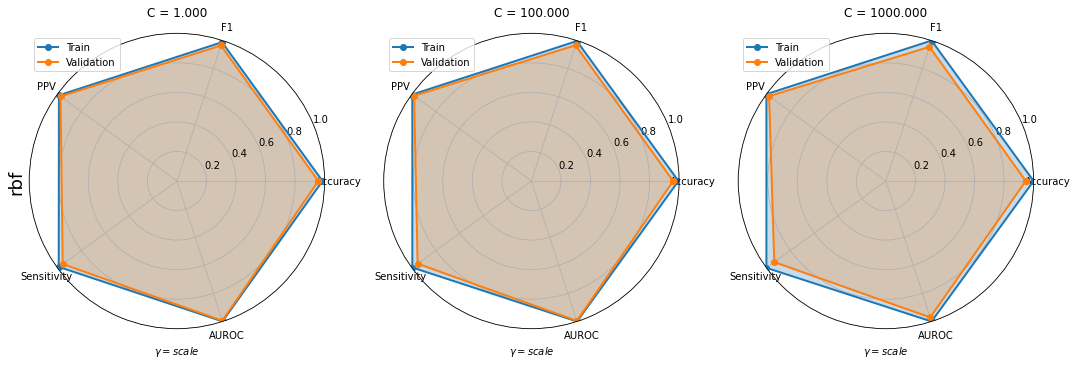

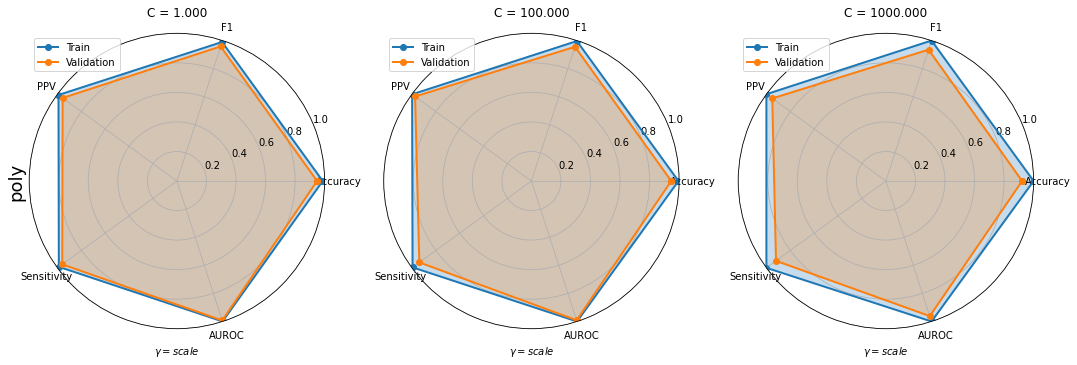

In [63]:
clf_type = ['rbf', 'scale']
plot_radar(svm_nonlin, clf_type)
clf_type = ['poly', 'scale']
plot_radar(svm_nonlin, clf_type)

Sensitivity is 0.97
Specificity is 0.93
PPV is 0.96
NPV is 0.95
Accuracy is 0.96
F1 is 0.96
LOSS is 0.09
AUROC is 0.977


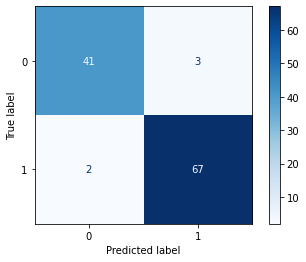

In [106]:
y_pred_test = best_svm_nonlin.predict(X_test) #NOTICE NOT TO USE THE STANDARDIZED DATA.
y_pred_proba_test = best_svm_nonlin.predict_proba(X_test)
#--------------------------Impelment your code here:-------------------------------------
y_pred_test_sc=np.where(y_pred_test==0, -1, y_pred_test)
y_test_sc=np.where(y_test==0, -1, y_test)

TN = calc_TN(y_test, y_pred_test)
TP = calc_TP(y_test, y_pred_test)
FN = calc_FN(y_test, y_pred_test)
FP = calc_FP(y_test, y_pred_test)
Se = TP/(TP+FN)
Sp = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
Acc = (TP+TN)/(TP+TN+FP+FN)
F1 = (2*PPV*Se)/(PPV+Se)
LOSS=hinge_loss(y_test_sc,y_pred_test_sc)
print(f'Sensitivity is {Se:.2f}')
print(f'Specificity is {Sp:.2f}')
print(f'PPV is {PPV:.2f}')
print(f'NPV is {NPV:.2f}')
print(f'Accuracy is {Acc:.2f}')
print(f'F1 is {F1:.2f}')
print(f'LOSS is {LOSS:.2f}')
plot_confusion_matrix(svm_nonlin, X_test, y_test, cmap=plt.cm.Blues)
plt.grid(False)
#------------------------------------------------------------------------------------------
print('AUROC is {:.3f}'.format(roc_auc_score(y_test, y_pred_proba_test[:,1])))

C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Sensitivity is 0.90
Specificity is 0.93
PPV is 0.95
NPV is 0.85
Accuracy is 0.91
F1 is 0.93
AUROC is 0.971


NameError: name 'importance' is not defined

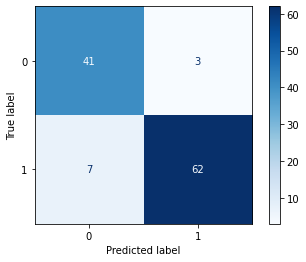

In [110]:
#random forest
from sklearn.metrics import plot_confusion_matrix, roc_auc_score,plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
rfc = Pipeline(steps=[('scale', StandardScaler()), ('rfc', RandomForestClassifier(max_depth=4, random_state=0, criterion='gini'))])
rfc.fit(X_train, y_train)
# importance = rfc.feature_importances_
y_pred_test = rfc.predict(X_test) #NOTICE NOT TO USE THE STANDARDIZED DATA.
y_pred_proba_test = rfc.predict_proba(X_test)
#--------------------------Impelment your code here:-------------------------------------
TN = calc_TN(y_test, y_pred_test)
TP = calc_TP(y_test, y_pred_test)
FN = calc_FN(y_test, y_pred_test)
FP = calc_FP(y_test, y_pred_test)
Se = TP/(TP+FN)
Sp = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
Acc = (TP+TN)/(TP+TN+FP+FN)
F1 = (2*PPV*Se)/(PPV+Se)
print(f'Sensitivity is {Se:.2f}')
print(f'Specificity is {Sp:.2f}')
print(f'PPV is {PPV:.2f}')
print(f'NPV is {NPV:.2f}')
print(f'Accuracy is {Acc:.2f}')
print(f'F1 is {F1:.2f}')
plot_confusion_matrix(rfc,X_test, y_test, cmap=plt.cm.Blues)
plt.grid(False)
#------------------------------------------------------------------------------------------
print('AUROC is {:.3f}'.format(roc_auc_score(y_test, y_pred_proba_test[:,1])))

# print(importance)